In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
from torchvision.utils import make_grid #격자 형태의 이미지 생성
import imageio #gif 파일 생성
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# 패션 아이템 데이터 불러오기
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5))])
trainset = FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=100, shuffle=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

100%|██████████| 26421880/26421880 [00:03<00:00, 8600241.57it/s] 


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 142863.60it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2658248.64it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6179815.97it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [11]:
# 생성자 구축하기
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.n_features = 128 #잠재 변수 크기는 임의로
    self.n_out = 784 #잠재 변수로부터 784(28*28) 크기의 벡터 생성
    self.linear = nn.Sequential(
        nn.Linear(self.n_features,256),
        nn.LeakyReLU(0.2), #기울기 사라짐 방지를 위해 LeakyReLU(0.2) 사용
        nn.Linear(256, 512),
        nn.LeakyReLU(0.2),
        nn.Linear(512, 1024),
        nn.LeakyReLU(0.2),
        nn.Linear(1024, self.n_out),
        nn.Tanh())
    
  def forward(self, x):
    x = self.linear(x)
    x = x.view(-1, 1, 28, 28) #784 크기의 벡터를 크기가 28*28인 흑백 이미지로 변경하여 새로운 이미지 생성
    return x

In [12]:
# 구별자 구축하기
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.n_in = 784 #이미지를 일렬로 편 크기
    self.n_out = 1 #진위여부 판단하기 위한 하나의 숫자
    self.linear = nn.Sequential(
        nn.Linear(self.n_in, 1024),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),
        nn.Linear(1024, 512),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),
        nn.Linear(512, 256),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),
        nn.Linear(256, self.n_out),
        nn.Sigmoid()) #0과 1사이의 값이 출력될 수 있도록 시그모이드 함수 마지막에 적용
    
  def forward(self, x):
    x = x.view(-1, 784) #이미지를 벡터 형태로 변경
    x = self.linear(x)
    return x

In [13]:
# 모델 정의하기
generator = Generator().to(device) #생성자 선언
discriminator = Discriminator().to(device) #구별자 선언

In [14]:
# 손실 함수 및 최적화 기법 정의하기
g_optim = optim.Adam(generator.parameters(), lr=2e-4) #생성자 변수 최적화를 위한 Adam 정의
d_optim = optim.Adam(discriminator.parameters(),lr=2e-4) #구별자 변수 최적화를 위한 Adam 정의
# 학습 동안 손실 함수값과 샘플 이미지 저장을 위한 리스트 생성
g_losses = []
d_losses = []
images = []
criterion = nn.BCELoss() #손실 함수는 이진 크로스 엔트로피 함수 사용

In [15]:
# 잠재 변수 및 라벨 정의하기

# 크기가 128인 잠재 변수 n개 무작위로 생성, 손실 함수에서 이미지의 진위 여부에 대한 계산
# 진짜 데이터의 라벨은 1, 생성자로부터 만들어진 이미지의 라벨은 0
def noise(n, n_features=128):
  data = torch.randn(n, n_features)
  return data.to(device)

# 이를 위해 1과 0 라벨을 만들어주는 함수 정의
def label_ones(size):
  data = torch.ones(size, 1)
  return data.to(device)

def label_zeros(size):
  data = torch.zeros(size, 1)
  return data.to(device)

In [16]:
# 구별자 학습 함수 정의하기
def train_discriminator(optimizer, real_data, fake_data): #최적화 함수, 진짜 이미지, 가짜 이미지
  n = real_data.size(0) #이미지 개수
  optimizer.zero_grad()
  prediction_real = discriminator(real_data) #진짜 이미지 판별
  d_loss = criterion(prediction_real, label_ones(n)) #이미지 수만큼 라벨 1을 넣어 손실 함수 계산
  prediction_fake = discriminator(fake_data) #가짜 이미지 판별
  g_loss = criterion(prediction_fake, label_zeros(n)) #이미지 수만큼 라벨 0을 넣어 손실 함수 계산
  loss = d_loss + g_loss #최종 손실함수 = 두 손실함수의 합
  loss.backward()
  optimizer.step() #구별자 업데이트
  return loss.item()

In [17]:
# 생성자 학습 함수 정의
def train_generator(optimizer, fake_data): #최적화 함수, 가짜 이미지
  n = fake_data.size(0) #이미지 개수
  optimizer.zero_grad()
  prediction = discriminator(fake_data) #가짜 이미지를 구별자에 넣어 판별
  # 생성자 입장에서는 구별자가 진짜 이미지라고 판단하도록 업데이트가 되어야 하므로 라벨 1을 넣어 손실 함수 계산
  loss = criterion(prediction, label_ones(n))
  loss.backward()
  optimizer.step()
  return loss.item()

In [18]:
# 모델 학습하기
test_noise = noise(64) #검증을 위한 무작위 잠재 변수 64개 생성
l = len(trainloader) #평균 손실값을 구하는 데 사용하는 배치 수
for epoch in range(151):
  g_loss = 0.0 #각 epoch마다 손실값 초기화
  d_loss = 0.0
  for data in trainloader:
    imgs, _ = data #진짜 이미지
    n = len(imgs) #진짜 이미지 개수
    fake_data = generator(noise(n)).detach() #진짜 이미지 개수만큼 가짜 이미지 생성, detach()를 통해 불필요한 requires_grad 비활성화
    real_data = imgs.to(device)
    d_loss += train_discriminator(d_optim, real_data, fake_data) #구별자 업데이트하고, 손실함수 값 누적
    fake_data = generator(noise(n))
    g_loss += train_generator(g_optim, fake_data) #생성자 업데이트하고, 손실함수 값 누적
  
  img = generator(test_noise).detach().cpu() #검증을 위해 고정된 잠재 변수를 넣어 이미지 생성
  img = make_grid(img) #변화를 알아보기 위한 격자 형태의 이미지
  images.append(img)
  g_losses.append(g_loss/l) #손실 함수값의 변화 저장
  d_losses.append(d_loss/l)
  if epoch % 10 == 0: #에폭 10 단위마다 손실값 출력
    print('Epoch {}: g_loss: {:.3f} d_loss: {:.3f}\r'.format(epoch, g_loss/l, d_loss/l))

Epoch 0: g_loss: 2.623 d_loss: 0.679
Epoch 10: g_loss: 1.741 d_loss: 0.846
Epoch 20: g_loss: 1.466 d_loss: 0.956
Epoch 30: g_loss: 1.406 d_loss: 0.964
Epoch 40: g_loss: 1.245 d_loss: 1.055
Epoch 50: g_loss: 1.193 d_loss: 1.074
Epoch 60: g_loss: 1.200 d_loss: 1.083
Epoch 70: g_loss: 1.164 d_loss: 1.104
Epoch 80: g_loss: 1.150 d_loss: 1.124
Epoch 90: g_loss: 1.080 d_loss: 1.167
Epoch 100: g_loss: 1.052 d_loss: 1.173
Epoch 110: g_loss: 1.070 d_loss: 1.168
Epoch 120: g_loss: 1.053 d_loss: 1.193
Epoch 130: g_loss: 1.062 d_loss: 1.183
Epoch 140: g_loss: 1.034 d_loss: 1.198
Epoch 150: g_loss: 1.002 d_loss: 1.213


In [22]:
# 모델 저장하기
import os

directory = './models'
if not os.path.exists(directory):
    os.makedirs(directory)
    
torch.save(discriminator.state_dict(), './models/fmnist_disc.pth')
torch.save(generator.state_dict(), './models/fmnist_gner.pth')

In [23]:
# 검증 이미지 변화를 gif 파일로 저장하기
to_image = transforms.ToPILImage() #images 리스트 원소 하나는 격자 형태로 만들어진 이미지 모임(3, 242, 242) -> toPILImage()로 (242, 242, 3)으로 변환
imgs = [np.array(to_image(i)) for i in images] 
imageio.mimsave('fashion_items.gif', imgs) #이미지를 넘파이 배열로 변경하여 gif파일로 만듦

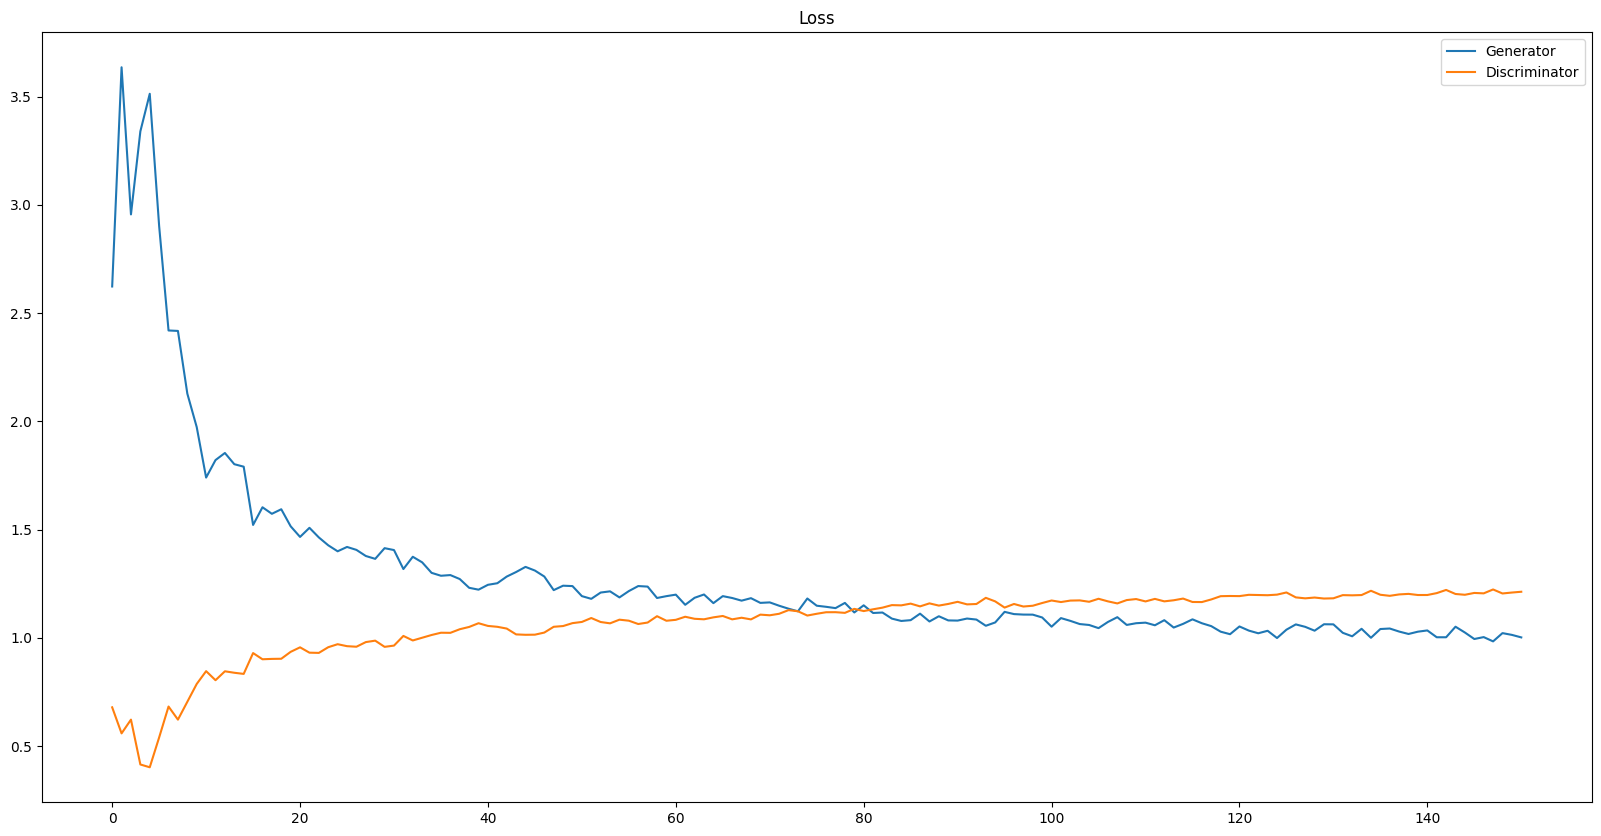

In [24]:
# 손실 함수값 그래프 그리기
plt.figure(figsize=(20,10))
plt.plot(g_losses)
plt.plot(d_losses)
plt.legend(['Generator', 'Discriminator'])
plt.title('Loss')
plt.savefig('gan_loss.png')